In [ ]:
!pip install comet_ml

In [2]:
#import comet_ml in the top of your file
from comet_ml import Experiment

In [ ]:
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="xxxxxxxxxxxxxxxxx", project_name="litigation",
                        workspace="zzzz", 
                        log_code = True,
                        log_graph=True, 
                        auto_param_logging=True,
                        auto_metric_logging = True,
                        display_summary=True, 
                        log_env_cpu=True, )

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!nvidia-smi

In [ ]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .
import os
os.chdir("bert-sklearn")
print(os.listdir())

In [9]:
import torch
print('pytorch version:', torch.__version__)
print('GPU:',torch.cuda.get_device_name(0))

pytorch version: 1.6.0+cu101
GPU: Tesla T4


In [16]:
import os
import math
import random
import csv
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statistics as stats

from bert_sklearn import BertClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import string
import nltk
pd.set_option('display.max_colwidth', 150)

In [10]:
%%bash
wget -q -nc https://www.dropbox.com/s/f550mm675z3n68w/LitigatedDataset.csv /content/
ls

bert_sklearn
demo.ipynb
demo_tuning_hyperparams.ipynb
glue_examples
LICENSE
LitigatedDataset.csv
Options.md
other_examples
README.md
setup.py
tests


In [11]:
import pandas as pd
df = pd.read_csv('LitigatedDataset.csv')

In [12]:
df.head()

,Abstract,IsLitigated
0,"Systems, methods, and computer program produc...",Yes
1,A method is disclosed involving acquiring a p...,Yes
2,This invention presents a method for pricing ...,Yes
3,Contact structures exhibiting resilience or c...,No
4,A checkless cash advance settlement system an...,Yes


In [17]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def transform_text(text):
  text = "".join([word for word in text if word not in string.punctuation]) #removing punctuation
  tokens = re.split('\W+', text)
  tokenized_text = [word.lower() for word in tokens if word not in stopwords] #removing stopwords and make every lower case
  text = [wn.lemmatize(word) for word in tokenized_text] #lemmatize text
  return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
df['Abstract_cleaned'] = df['Abstract'].apply(transform_text)

In [20]:
X = df['Abstract']
y = df['IsLitigated']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# PIPELINE

Logistic Regression  with Tfidf and CountVectorizer

In [21]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

Tune HyperParameters

In [22]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline

pipe  = Pipeline(steps= [('vectorizer',TfidfVectorizer(analyzer=transform_text)),
                     ('classifier',RandomForestClassifier())])


# Create dictionary with candidate learning algorithms and their hyperparameters
param = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10), 
                 "vectorizer" : [TfidfVectorizer(analyzer=transform_text), CountVectorizer(analyzer=transform_text)], 
                 "vectorizer__ngram_range" : [(1,1), (2,2), (3,3)]
                 },

                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'],
                 "classifier__C": np.logspace(0, 4, 10),
                 "classifier__solver":['newton-cg','saga','sag','liblinear'], ##This solvers don't allow L1 penalty
                 "vectorizer" : [TfidfVectorizer(analyzer=transform_text), CountVectorizer(analyzer=transform_text)], 
                 "vectorizer__ngram_range" : [(1,1), (2,2), (3,3)]
                 },
         
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [None, 10, 50, 90, 130],
                 "classifier__max_depth":[None, 5, 7, 9 , 11],
                 "classifier__min_samples_leaf":[None, 1,5,9],
                 "classifier__max_leaf_nodes": [None, 2, 5,10], 
                 "vectorizer" : [TfidfVectorizer(analyzer=transform_text), CountVectorizer(analyzer=transform_text)], 
                  "vectorizer__ngram_range" : [(1,1), (2,2), (3,3)]
                }, 
                {
                  "classifier": [BertClassifier(train_batch_size = 4)],
                  "vectorizer": ['passthrough']
                }
         ]


random_search = RandomizedSearchCV(pipe, param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = random_search.fit(X_train,y_train)

Building sklearn text classifier...


In [23]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function transform_text at 0x7fd2c0c4e158>,
                                 ngram_range=(2, 2))),
                ('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=9,
                                        n_estimators=90))])
The mean accuracy of the model is: 0.6615384615384615


In [24]:
final = Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer= transform_text)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_leaf_nodes=5,
                                        min_samples_leaf=9, n_estimators=90))])

In [25]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context

In [29]:
final

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function transform_text at 0x7fd2c0c4e158>)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, max_leaf_nodes=5,
                                        min_samples_leaf=9, n_estimators=90))])

In [30]:
classes = ['Litigated', 'NotLitigated']

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text  # both are new in 0.21

from sklearn.tree import DecisionTreeClassifier

tfidf_transformer = TfidfVectorizer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

rf = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=5, min_samples_leaf=9)
rf.fit(X_train_tfidf, y_train);



In [32]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text  # both are new in 0.21

from sklearn.tree import DecisionTreeClassifier

tfidf_transformer = TfidfVectorizer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
rf1 = RandomForestClassifier(max_depth=5, max_leaf_nodes=5,
                                        min_samples_leaf=9, n_estimators=90)
rf1.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=5, min_samples_leaf=9,
                       n_estimators=90)

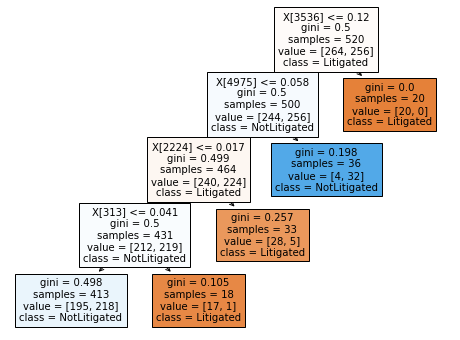

In [33]:
plt.figure(figsize=(8, 6))
plot_tree(rf, class_names=classes, filled=True)
plt.savefig('/content/tree.png',format='png',bbox_inches = "tight")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = best_model.predict(X_test)

print("\nResults\nConfusion matrix \n {}".format(confusion_matrix(y_test, y_pred)))

f1 = f1_score(y_test, y_pred, pos_label='No')
precision = precision_score(y_test, y_pred, pos_label='No')
recall = recall_score(y_test, y_pred, pos_label='No')
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)

print("F1 score is {:6.3f}".format(f1))
print("Precision score is {:6.3f}".format(precision))
print("Recall score is {:6.3f}".format(recall))
print("Train score is {:6.3f}".format(train_accuracy))
print("Test score is {:6.3f}".format(test_accuracy))

#these will be logged to your sklearn-demos project on Comet.ml
params={"model_type":"RandomForest",
        "param_grid":str(param),
        "stratify":True
}

metrics = {"f1":f1,
"recall":recall,
"precision":precision
}

experiment.log_dataset_hash(X_train)
experiment.log_metric("train_accuracy", train_accuracy)
experiment.log_metric("test_accuracy", test_accuracy)
experiment.log_parameters(params)
experiment.log_metrics(metrics)
experiment.log_confusion_matrix(matrix = cm)
experiment.set_code()


Results
Confusion matrix 
 [[30 31]
 [30 39]]


COMET WARNING: truncated string; too long: '[{'classifier': [LogisticRegression()], 'classifier__penalty': ['l2', 'l1'], 'classifier__C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]), 'vectorizer': [TfidfVectorizer(analyzer=<function transform_text at 0x7f4d8f860158>), CountVectorizer(analyzer=<function transform_text at 0x7f4d8f860158>)], 'vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)]}, {'classifier': [LogisticRegression()], 'classifier__penalty': ['l2'], 'classifier__C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]), 'classifier__solver': ['newton-cg', 'saga', 'sag', 'liblinear'], 'vectorizer': [TfidfVectorizer(analyzer=<function transform_text at 0x7f4d8f860158>), CountVectorizer(analyzer=<function transform_t

F1 score is  0.496
Precision score is  0.500
Recall score is  0.492
Train score is  0.810
Test score is  0.531


In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
df_litigated = df[df.IsLitigated == "Yes"]
str_litigated = ''.join(list(df_litigated.Abstract))
df_not_litigated = df[df.IsLitigated == "No"]
str_not_litigated = ''.join(list(df_not_litigated.Abstract))

# Not Litigated - Word Cloud

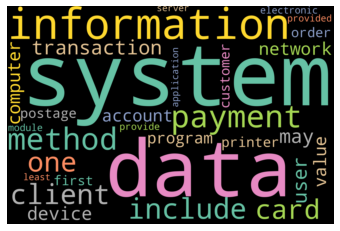

In [ ]:
# Start with one review:
text = str_not_litigated
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords, max_words=30).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("/content/not_litigated.png")
experiment.log_figure('not_litigated.png')
plt.show()

In [ ]:
experiment.log_image('/content/not_litigated.png')

In [ ]:
experiment.log_image('/content/tree.png')

In [ ]:
experiment.log_image('/content/litigated.png')

## Litigated - Word Cloud

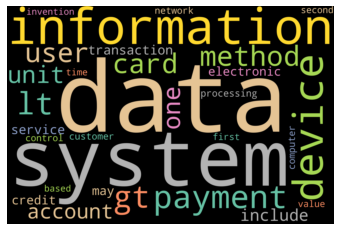

In [ ]:
# Start with one review:
text = str_litigated
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, max_words=30,colormap='Set2', collocations=False, stopwords = stopwords, background_color="black").generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("/content/litigated.png")
plt.show()